![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [ ]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

In [ ]:
import numpy as np
data = np.load('/content/drive/My Drive/AIML/Labs/Datasets/images.npy', allow_pickle = True)

In [ ]:
np.random.seed(4)
tensorflow.random.set_seed(4)

### Check one sample from the loaded "images.npy" file  (3 marks)
- Hint: print data[10][1] 

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


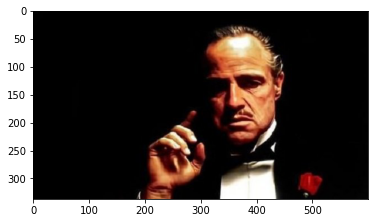

In [ ]:
print(data[10][1])

import matplotlib.pyplot as plt
plt.imshow(data[10][0])

### Set image dimensions   (2 marks)
- Initialize image height, image width with value: 224 

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [ ]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### Split the data into training and testing (3 marks)
- 400 images in training
- 9 images in testing data

Training data

In [ ]:
X_train = X[:399]
y_train = masks[:399]

Testing data

In [ ]:
X_test = X[400:]
y_test = masks[400:]

### Print a sample training image, image array and its mask (3 marks)

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

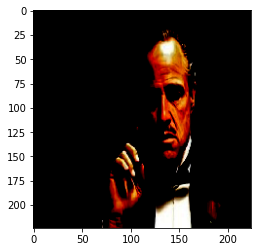

In [ ]:
plt.imshow(X_train[10])
print(X_train[10,:,:])

Print the mask

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


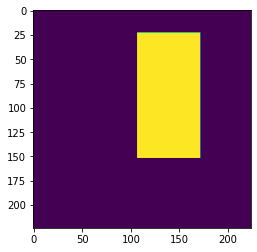

In [ ]:
plt.imshow(y_train[10])
print(y_train[10,:,:])

## Create the model (7 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model

def create_model(trainable=True):
    inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name="input_image")
    model = MobileNet(input_tensor = inputs, include_top=False, alpha=1.0, weights="imagenet")
    
    for layer in model.layers:
        layer.trainable = trainable
  
    skip_connection_names = ['input_image','conv_pw_1_relu', 'conv_pw_3_relu', 'conv_pw_5_relu','conv_pw_11_relu']
    model_output = model.get_layer("conv_pw_13_relu").output

    f = [14, 28, 56, 112, 224]
    x = model_output

    for i in range(1, len(skip_connection_names)+1, 1):
      x_skip = model.get_layer(skip_connection_names[-i]).output
      x = UpSampling2D((2,2))(x)
      x = Concatenate()([x, x_skip])

      x = Conv2D(f[-i],(3,3), padding = 'same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)

      x = Conv2D(f[-i], (3,3), padding = 'same')(x)
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
    
    x = Conv2D(1, (1,1), padding = 'same')(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs, x)
    return model
  

### Call the create_model function (2 marks)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [ ]:
model = create_model(trainable=True)

### Print model summary (2 marks)

In [ ]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
_______________________________________________________________________________________

### Define dice coefficient function (3 marks)
- Create a function to calculate dice coefficient


In [ ]:
epsilon = 1e-7

def dice_coef(y_true, y_pred):
    y_true = tensorflow.keras.layers.Flatten()(y_true)
    y_pred = tensorflow.keras.layers.Flatten()(y_pred)
    intersection = tensorflow.reduce_sum(y_true * y_pred)
    union = (tensorflow.reduce_sum(y_true + y_pred) + epsilon)
    return (2. * intersection + epsilon) / union

### Define loss function (3 marks)

In [ ]:
def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

### Compile the model (3 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [ ]:
model.compile(loss = dice_loss, optimizer='adam',metrics=dice_coef) 

### Define callbacks (3 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

filepath="/content/drive/My Drive/AIML/Labs/cv_face_mask_weights.hdf5"

callbacks = [
             ModelCheckpoint(filepath, monitor = 'val_loss', save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch', verbose = 0),
             ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4),
             EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = False)
]

### Fit the model (3 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [ ]:
model.fit(X_train, y_train, batch_size=1, epochs = 5, validation_data=(X_test, y_test), callbacks = callbacks)

Epoch 1/5
399/399 [==============================] - 9s 23ms/step - loss: 0.3492 - dice_coef: 0.6508 - val_loss: 0.5294 - val_dice_coef: 0.4706
Epoch 2/5
399/399 [==============================] - 9s 24ms/step - loss: 0.3324 - dice_coef: 0.6676 - val_loss: 0.5812 - val_dice_coef: 0.4188
Epoch 3/5
399/399 [==============================] - 10s 25ms/step - loss: 0.3276 - dice_coef: 0.6724 - val_loss: 0.5493 - val_dice_coef: 0.4507
Epoch 4/5
399/399 [==============================] - 9s 23ms/step - loss: 0.3087 - dice_coef: 0.6913 - val_loss: 0.4514 - val_dice_coef: 0.5486
Epoch 5/5
399/399 [==============================] - 10s 24ms/step - loss: 0.2900 - dice_coef: 0.7100 - val_loss: 0.4631 - val_dice_coef: 0.5369


### Get the predicted mask for a test image   (3 marks)

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


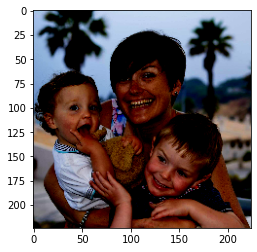

In [ ]:
plt.imshow(X_test[0])

Show original mask for test image

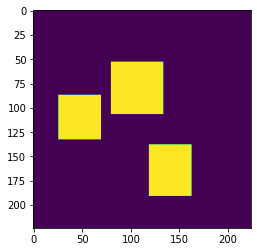

In [ ]:
plt.imshow(y_test[0])

Predict the mask on the test image

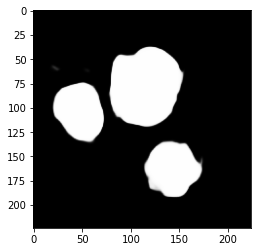

In [ ]:
y_pred = model.predict(X_test)

def plot_mask(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

mask = plot_mask(y_pred[0])
plt.imshow(mask)

### Impose the mask on the test image (3 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

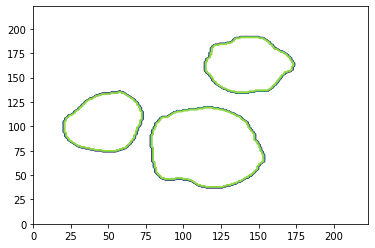

In [ ]:
y_alpha = (y_pred > 0.5).astype(np.uint8)
plt.contour(y_alpha[0].squeeze())